<a href="https://colab.research.google.com/github/SURESHBEEKHANI/Autoencoders/blob/main/Lecture_31_Variational_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

**Autoencoders** are a particular type of neural network, just like classifiers. Autoencoders are similar to classifiers in the sense that they compress data. However, where classifiers condense all the data of an image into a single label, autoencoders compress the data into a **latent vector**, often denoted $z$ in literature, with the goal of preserving the opportunity to recreate the exact same image in the future. Because autoencoders learn representations instead of labels, autoencoders belong to representation learning, a subfield of machine learning, but not necessarily deep learning.

While recreating the same data from a compressed version might seem like an impossible task. However, _you_ can actually do the same. You probably have no difficulty memorizing the following sequence:

$$1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27...$$

I bet you haven't looked at every item, but you can still write down the sequence perfectly because you recognized a pattern: all uneven numbers, starting from 1.

This is what autoencoders do: they find patterns in data.

## Architecture
Autoencoders consist of two networks:

* Encoder
* Decoder

The goal of the **encoder** is to compress an image, video, or any piece of data that can be represented as a tensor, into a _latent vector_. The **decoder** does, as you might have guessed, the exact opposite.

To maximize performance, minimize the loss that is, encoders and decoders are typically symmetrical together. Naturally, the input size is equal to the output size of an autoencoder.

Autoencoders always have less input neurons in the middle layer than in the input and output layer. This is called the **bottleneck**. If it weren't for this bottleneck, the autoencoders could just copy this data over from the input to the output layer without compressing it.

![](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png) [source](https://en.wikipedia.org/wiki/File:Autoencoder_structure.png)

## Training

Encoders and decoders _can_ be trained separately, but usually they are trained in one go. In order to do so, one stacks the coders together in one **stacked autoencoder**.

If one desires to train autoencoders separately, one starts by using the first hidden layer, discaring every other layer, except for the input and output layers of course. He uses the original training data at this point. Next, he uses the latent vector $z$ learnt by this mini-autoencoder and trains another autoencoder in the same way, treating the latent vectors as original data. Once the desired depth is reached, one can stack all output layers, which provided the latent vectors, together in a sinle encoder. This approach is not used in practise a lot, but literature might refer to it as greedy layerwise training so it's good to know what it means.

## Appliciations

While the phase "finding patterns" might not seem very interesting, there are a lot of exciting applications of autoencoders. We will look at three of those today:

1. Dense autoencoder: compressing data.
2. Convolutional autoencoder: a building block of DCGANs, self-supervised learning.
3. Denoising autoencoder: removing noise from poor training data.

While all of these applications use pattern finding, they have different use cases making autoencoders one of the most exciting topics of machine learning.

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from tensorflow import keras

## Loading the data

We will load MNIST, but without labels because representation learning is **unsupervised**, or **self-supervised** which is the prefered

In [4]:

# Load the MNIST dataset from Keras
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

# Normalize the training data to be in the range [0, 1]
x_train = x_train / 255.0

# Normalize the test data to be in the range [0, 1]
x_test = x_test / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## A simple autoencoder

Let's start by looking at the simplest possible autoencoder.

The `encoder` is a sequential neural network with $28 \times 28$ input neurons, $100$ neurons in the second layer and $30$ in the third. The third layer is called the "bottleneck". Feel free to play around with this variable to see how it affects results.

In [5]:

# Create the encoder model
encoder = keras.models.Sequential([
    # Flatten the input images (28x28) into a 1D array of 784 elements
    keras.layers.Flatten(input_shape=[28, 28]),
    # Add a dense layer with 100 neurons and ReLU activation function
    keras.layers.Dense(100, activation="relu"),
    # Add another dense layer with 30 neurons and ReLU activation function
    keras.layers.Dense(30, activation="relu"),
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The decoder is the same, but in opposite order. Note that keras needs to know the input shape at this point. The input shape of the decoder is the shape of $z$, also called `zDim` as you will see later on.

In [6]:


# Create the decoder model
decoder = keras.models.Sequential([
    # Add a dense layer with 100 neurons and ReLU activation function, input shape is 30 (output from encoder)
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    # Add a dense layer with 784 neurons (28*28) and sigmoid activation function to output pixel values in range [0, 1]
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    # Reshape the output into the original image shape (28x28)
    keras.layers.Reshape([28, 28])
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now stack them for training:

In [7]:
# Stack the encoder and decoder models to create the autoencoder
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

Note that we use binary cross entropy loss in stead of categorical cross entropy. The reason for that is because we are not classifying latent vectors to belong to a particular class, we do not even have classes!, but rather are trying to predict whether a pixel should be activated or not.

In [8]:
# Compile the stacked autoencoder model
stacked_autoencoder.compile(
    # Use binary cross-entropy loss function for binary input data (normalized pixel values)
    loss="binary_crossentropy",
    # Use the Adam optimizer for efficient training
    optimizer='adam'
)


Notice how the $x$ and $y$, both $x$, `x_train` if you like, are equal:

In [9]:
# Train the stacked autoencoder model
history = stacked_autoencoder.fit(
    # Input and target data are both x_train (input images) for reconstruction
    x_train, x_train,
    # Train for 10 epochs
    epochs=10,
    # Use x_test for validation during training
    validation_data=[x_test, x_test]
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1918 - val_loss: 0.1036
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.1023 - val_loss: 0.0949
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0952 - val_loss: 0.0918
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0927 - val_loss: 0.0902
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0911 - val_loss: 0.0885
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0895 - val_loss: 0.0876
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0886 - val_loss: 0.0871
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0876 - val_loss: 0.0863
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0871 - val_loss: 0.0861
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0869 - val_loss: 0.0861


Let's look at how the autoencoder reconstructs images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


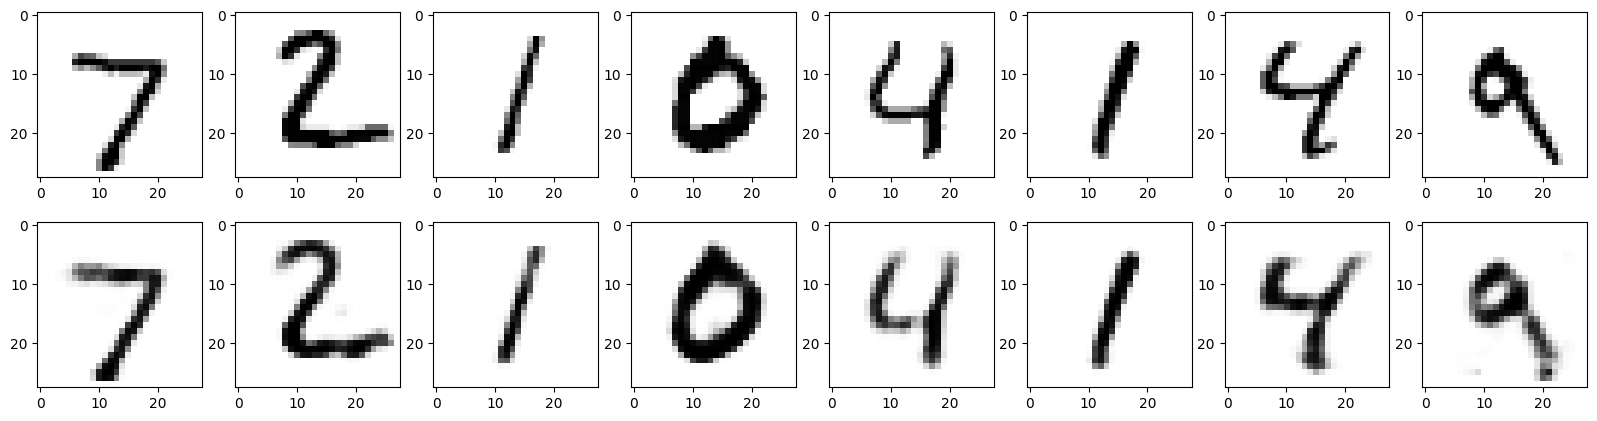

In [10]:

# Set the figure size for the plot
figsize(20, 5)

# Iterate over a range of 8 examples from the test set
for i in range(8):
    # Plot the original image from the test set
    subplot(2, 8, i+1)
    # Make a prediction using the stacked autoencoder on the current test image
    pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
    # Display the original image
    imshow(x_test[i], cmap="binary")

    # Plot the reconstructed image by the stacked autoencoder
    subplot(2, 8, i+8+1)
    # Display the reconstructed image
    imshow(pred.reshape((28, 28)), cmap="binary")


Just from this vector:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


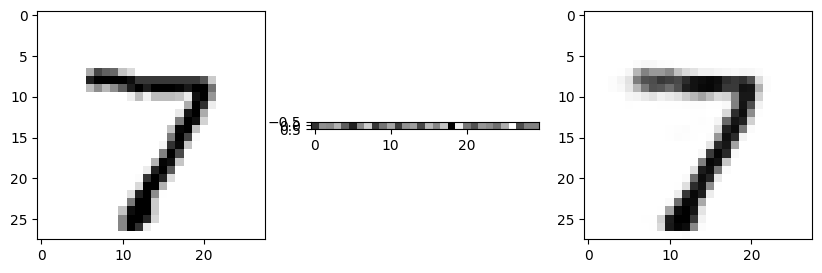

In [11]:

# Set the index i to choose a specific example from the test set
i = 0  # Change this number to select a different example

# Set the figure size for the plot
figsize(10, 5)

# Plot the original image
subplot(1, 3, 1)
imshow(x_test[i], cmap="binary")

# Plot the latent vector representation obtained from the encoder
subplot(1, 3, 2)
# Predict the latent vector representation of the selected test image
latent_vector = encoder.predict(x_test[i].reshape((1, 28, 28)))
imshow(latent_vector, cmap="binary")

# Plot the reconstructed image from the latent vector using the decoder
subplot(1, 3, 3)
# Reconstruct the image from the latent vector representation
pred = decoder.predict(latent_vector)
imshow(pred.reshape((28, 28)), cmap="binary")


In [12]:
# 30 / (28 * 28), 1 - 30 / (28 * 28)

# Calculate the sparsity constraints
sparsity_low = 30 / (28 * 28)  # Lower bound for sparsity constraint
sparsity_high = 1 - 30 / (28 * 28)  # Upper bound for sparsity constraint

# Print the calculated values
print(sparsity_low, sparsity_high)



0.03826530612244898 0.9617346938775511


That's 96.2% compression!

## Convolutional autoencoder

Apart from data compression, autoencoders can also be used for self-supervised image classification.

The first layers of the encoder learn to recognize patterns in the data very well in order to compress the data. If you don't have access to much labelled data, but a lot of unlabelled data, it's possible to train an autoencoder and copy the first layers from the autoencoder to the classifier network. This can be compared to transfer learning, where you only have to train the head afterwards.

It is well known that convolutional layers are perfect for finding patterns in data, so it's good to know they can also be used in autoencoders. To "de-convolve" images in the decoder, transposed convolutional layers are used. For more information on transposed convolutional layers, checkout [this blog post](https://rickwierenga.com/blog/s4tf/s4tf-gan.html) I have written which explains them in more detail. See the last section "Autoencoders and GANs" of this notebook for more information on the beautiful relation between GANs and autoencoders.

Let's look at a convolutional encoder:

In [13]:

# Define the encoder model using convolutional layers
encoder = keras.models.Sequential([
    # Reshape the input into a 28x28x1 image (grayscale)
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    # First convolutional layer with 16 filters, each of size 3x3, ReLU activation, and padding to maintain size
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    # Max pooling layer with pool size 2x2 to downsample the spatial dimensions
    keras.layers.MaxPool2D(pool_size=2),
    # Second convolutional layer with 32 filters, each of size 3x3, ReLU activation, and padding
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    # Max pooling layer
    keras.layers.MaxPool2D(pool_size=2),
    # Third convolutional layer with 64 filters, each of size 3x3, ReLU activation, and padding
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    # Max pooling layer
    keras.layers.MaxPool2D(pool_size=2)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The weights learnt by this encoder could be copied to the classifier.

In [14]:

# Predict the encoded representation of a single test image and print its shape
encoder.predict(x_test[0].reshape((1, 28, 28))).shape


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 3, 3, 64)

In [15]:

# Define the decoder model using convolutional transpose layers
decoder = keras.models.Sequential([
    # Convolutional transpose layer with 32 filters, each of size 3x3, stride 2, ReLU activation, and valid padding
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    # Convolutional transpose layer with 16 filters, each of size 3x3, stride 2, ReLU activation, and same padding
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    # Convolutional transpose layer with 1 filter, size 3x3, stride 2, sigmoid activation, and same padding
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    # Reshape the output into the original image shape (28x28)
    keras.layers.Reshape([28, 28])
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [16]:


# Stack the encoder and decoder models to create the stacked autoencoder
stacked_autoencoder = keras.models.Sequential([encoder, decoder])


In [17]:
# Compile the stacked autoencoder model
stacked_autoencoder.compile(
    # Use binary cross-entropy loss function for binary input data (normalized pixel values)
    loss="binary_crossentropy",
    # Use the Adam optimizer for efficient training
    optimizer='adam'
)


In [18]:
# Train the stacked autoencoder model on the training data
history = stacked_autoencoder.fit(
    # Input and target data are both x_train (input images) for reconstruction
    x_train, x_train,
    # Train for 10 epochs
    epochs=10,
    # Use x_test for validation during training
    validation_data=[x_test, x_test]
)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.1942 - val_loss: 0.0855
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0849 - val_loss: 0.0795
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0792 - val_loss: 0.0760
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0762 - val_loss: 0.0746
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0745 - val_loss: 0.0731
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0734 - val_loss: 0.0722
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0725 - val_loss: 0.0715
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0717 - val_loss: 0.0708
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0713 - val_loss: 0.0707
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0707 - val_loss: 0.0699


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


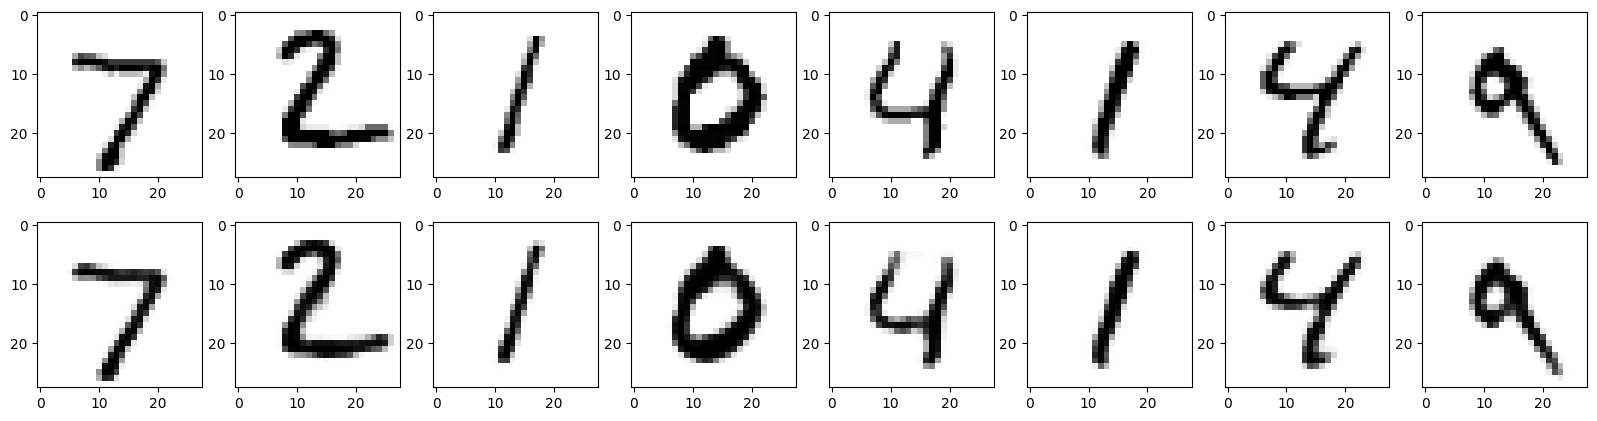

In [19]:
# Set the figure size for the plot
figsize(20, 5)

# Iterate over 8 examples from the test set
for i in range(8):
    # Plot the original image from the test set
    subplot(2, 8, i+1)
    # Make a prediction using the stacked autoencoder on the current test image
    pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
    # Display the original image
    imshow(x_test[i], cmap="binary")

    # Plot the reconstructed image by the stacked autoencoder
    subplot(2, 8, i+8+1)
    # Display the reconstructed image
    imshow(pred.reshape((28, 28)), cmap="binary")


Let's look at the weights the encoder learnt. Note that $\sqrt{64} = 8$.

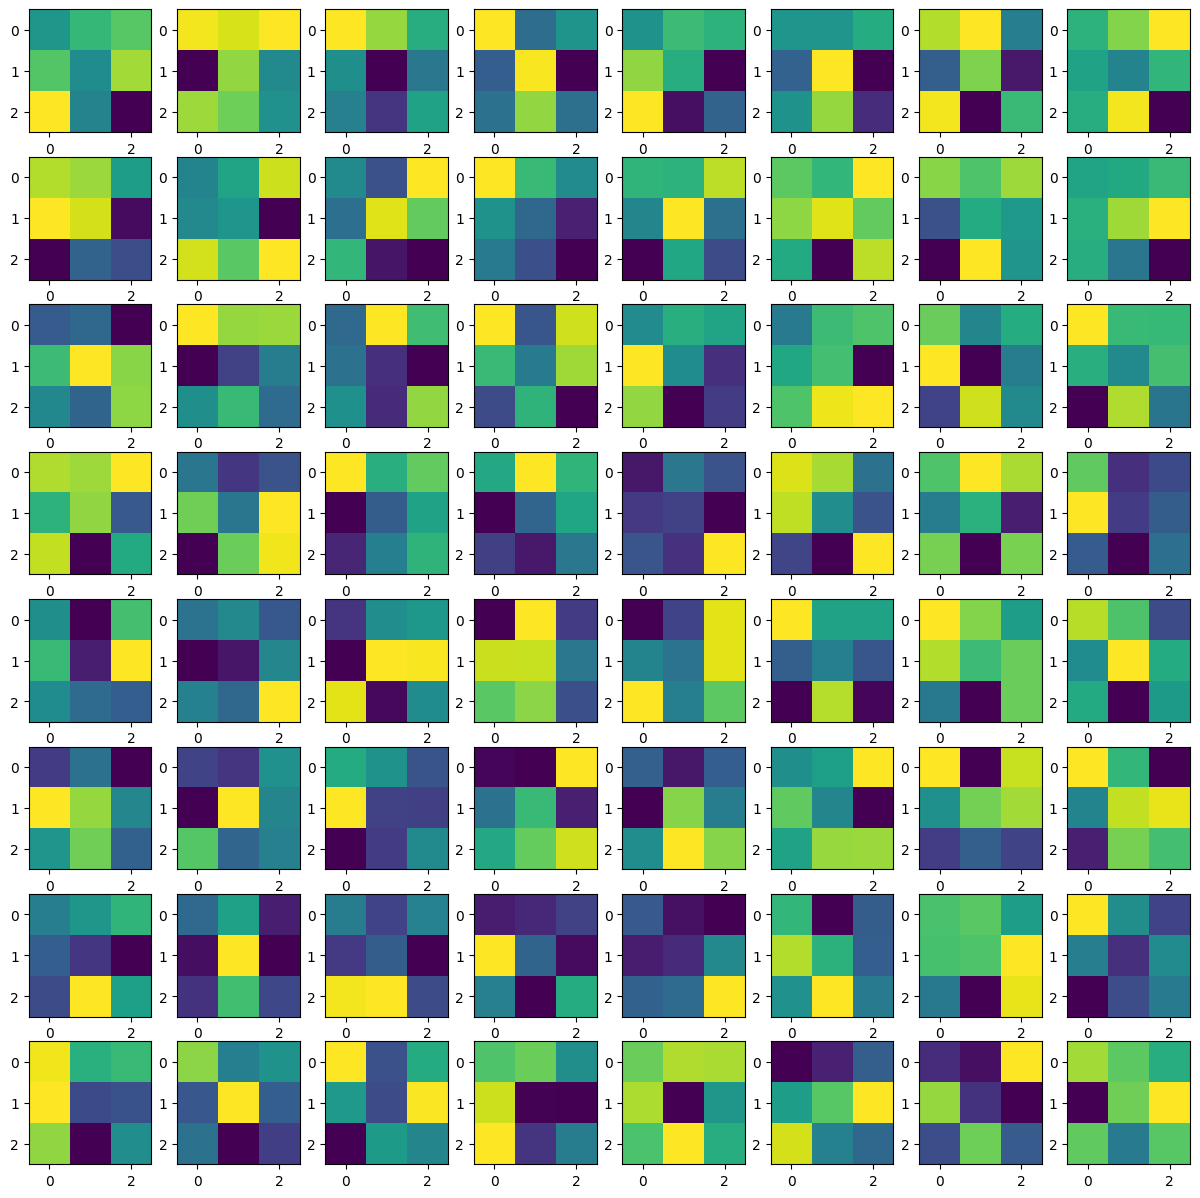

In [20]:
# Set the figure size for the plot
figsize(15, 15)

# Iterate over all filters in the last convolutional layer of the encoder
for i in range(8 * 8):
    # Plot each filter as a subplot in an 8x8 grid
    subplot(8, 8, i+1)
    # Display the weights (filters) of the convolutional layer
    imshow(encoder.layers[-2].weights[0][:, :, 0, i])


Visually not very pleasing, but proven to be effective as shown in the previous figure.

$3 \times 3 \times 64=576$ is still less than $28 \times 28 = 784$, thus creating a bottleneck, but much less compressed than the dense encoder making convolutional encoders less suitable for comporession. But thanks to their convolutional layers, they are great to use in cases where you want your autoencoder to find visual patterns in your data.

## Denoising autoencoder

The last application of autoencoders we look at today are denoising autoencoders. You probably have no difficulty classifying the images below as 7's.

In [21]:
import numpy as np

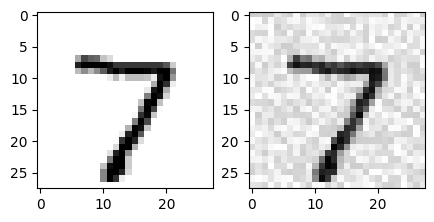

In [22]:
# Set the figure size for the plot
figsize(5, 10)

# Plot the original image from the test set
subplot(1, 2, 1)
imshow(x_test[0], cmap="binary")

# Plot the noisy version of the original image
subplot(1, 2, 2)
# Generate random noise and add it to the original image
noise = np.random.random((28, 28)) / 4
imshow(x_test[0] + noise, cmap="binary")


But in machine learning, this noise can be catasrophic. Luckily machine learning also has a solution for this problem: auto encoders!

By applying noise to the images inputted to the encoder and setting the clean image as desired output, $y$, an autoencoder can learn to remove noise from the image.

Let's look at such an encoder:

In [23]:
# Define the encoder model using dense (fully connected) layers
encoder = keras.models.Sequential([
    # Flatten the input images (28x28) into a 1D array of 784 elements
    keras.layers.Flatten(input_shape=[28, 28]),
    # Add a dense layer with 100 neurons and ReLU activation function
    keras.layers.Dense(100, activation="relu"),
    # Add another dense layer with 100 neurons and ReLU activation function
    keras.layers.Dense(100, activation="relu"),
    # Add a dense layer with 30 neurons and ReLU activation function to generate the latent space representation
    keras.layers.Dense(30, activation="relu")
])


In [24]:
# Define the decoder model using dense (fully connected) layers
decoder = keras.models.Sequential([
    # Add a dense layer with 100 neurons and ReLU activation function, input shape is 30 (latent space representation)
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    # Add another dense layer with 100 neurons and ReLU activation function
    keras.layers.Dense(100, activation="relu"),
    # Add a dense layer with 784 neurons (28*28) and sigmoid activation function to output pixel values in range [0, 1]
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    # Reshape the output into the original image shape (28x28)
    keras.layers.Reshape([28, 28])
])


In [25]:
# Combine the encoder and decoder models to create the stacked autoencoder
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [26]:
# Compile the stacked autoencoder model
stacked_autoencoder.compile(
    # Use binary cross-entropy loss function for binary input data (normalized pixel values)
    loss="binary_crossentropy",
    # Use the Adam optimizer for efficient training
    optimizer='adam'
)


Now create a dataset filled with noise:

In [27]:
# Add random noise to the training and test data
x_train_noise = x_train + ((np.random.random(x_train.shape)) / 4)
x_test_noise = x_test + ((np.random.random(x_test.shape)) / 4)


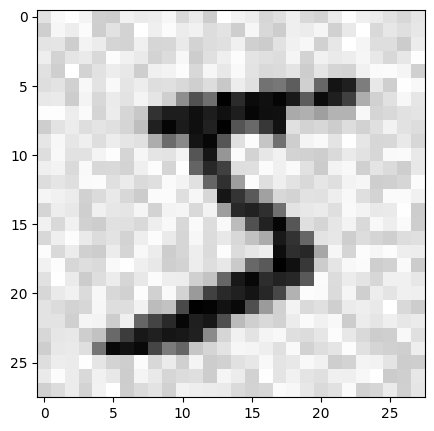

In [28]:
# Display an example of the noisy training data
imshow(x_train_noise[0], cmap="binary")


And finally train the stacked autoencoder with noise input data and clean output data.

In [29]:
# Train the stacked autoencoder model on the noisy training data
history = stacked_autoencoder.fit(
    # Input is the noisy training data (x_train_noise), target is the original clean training data (x_train)
    x_train_noise, x_train,
    # Train for 10 epochs
    epochs=10,
    # Use noisy test data (x_test_noise) for validation during training, with original clean test data (x_test) as target
    validation_data=[x_test_noise, x_test]
)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2136 - val_loss: 0.1249
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1220 - val_loss: 0.1122
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1112 - val_loss: 0.1052
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1057 - val_loss: 0.1018
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1025 - val_loss: 0.0999
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1006 - val_loss: 0.0982
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0993 - val_loss: 0.0973
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0986 - val_loss: 0.0975
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0976 - val_loss: 0.0959
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0968 - val_loss: 0.0953


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


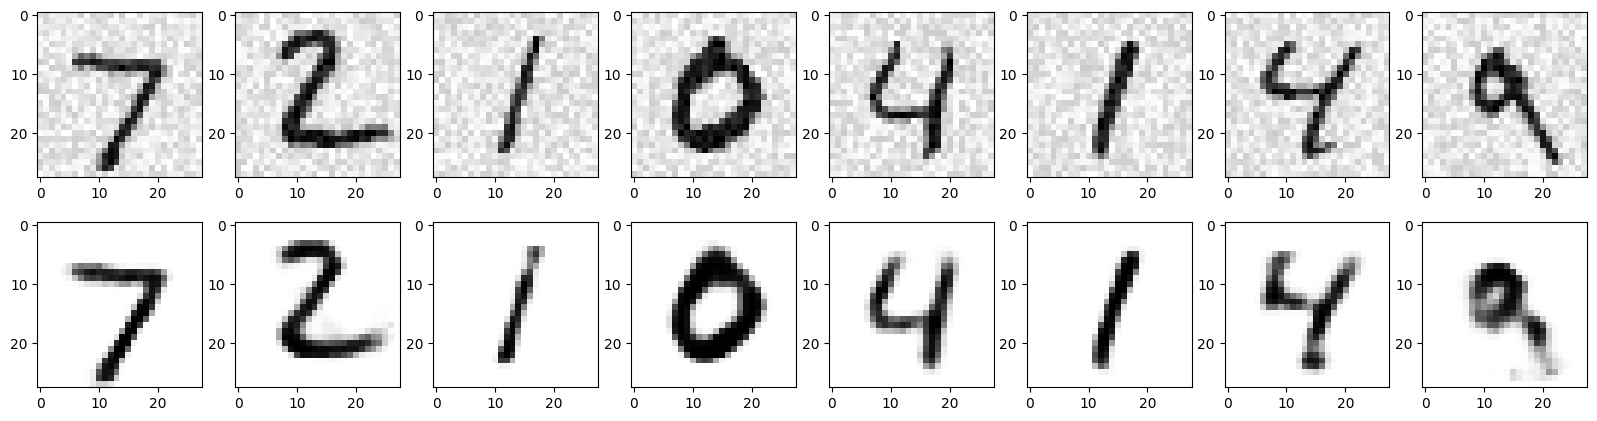

In [30]:
# Set the figure size for the plot
figsize(20, 5)

# Iterate over 8 examples from the noisy test set
for i in range(8):
    # Plot the noisy version of the original image from the test set
    subplot(2, 8, i+1)
    imshow(x_test_noise[i], cmap="binary")

    # Plot the reconstructed image by the stacked autoencoder using the noisy input
    subplot(2, 8, i+8+1)
    # Make a prediction using the stacked autoencoder on the current noisy test image
    pred = stacked_autoencoder.predict(x_test_noise[i].reshape((1, 28, 28)))
    # Display the reconstructed image
    imshow(pred.reshape((28, 28)), cmap="binary")


Mindblowing!